<a href="https://colab.research.google.com/github/geedoubledee/data620_finalproject/blob/main/DATA620_FinalProject_GDavis_BDavidoff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA620: Final Project
#### by Glen Davis and Brett Davidoff

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import nltk
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import re
import string
from textblob import TextBlob
import textwrap as tw

## Introduction

We load [a dataset containing every Oscars acceptance speech from 1939 to present](https://www.kaggle.com/datasets/yanncohen/oscars-acceptance-speeches-1939-2023).

In [ ]:
my_url = "https://raw.githubusercontent.com/geedoubledee/data620_finalproject/main/2024-04-13_oscar.csv"
oscars_df = pd.read_csv(my_url)
print(oscars_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2024 entries, 0 to 2023
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   year             2024 non-null   int64 
 1   award_no         2024 non-null   int64 
 2   date             2023 non-null   object
 3   location         2023 non-null   object
 4   pressented_by    2024 non-null   object
 5   category         2024 non-null   object
 6   honorary_reason  199 non-null    object
 7   film             1762 non-null   object
 8   song             72 non-null     object
 9   winner           2024 non-null   object
 10  speech           1884 non-null   object
dtypes: int64(2), object(9)
memory usage: 174.1+ KB
None


We remove some columns we won't need for our analysis and display the first five observations in the dataset.

In [ ]:
rem = ["date", "location", "honorary_reason", "song"]
oscars_df.drop(rem, axis = 1, inplace = True)
ren = {"pressented_by": "presented_by"}
oscars_df.rename(ren, axis = 1, inplace = True)
oscars_df.head()

,year,award_no,presented_by,category,film,winner,speech
0,1939,12,Spencer Tracy,Actress,Gone with the Wind,Vivien Leigh,"VIVIEN LEIGH:\n\r Ladies and gentlemen, please..."
1,1939,12,Fay Bainter,Actress in a Supporting Role,Gone with the Wind,Hattie McDaniel,HATTIE McDANIEL:\n\r Academy of Motion Picture...
2,1941,14,James Stewart,Actor in a Supporting Role,How Green Was My Valley,Donald Crisp,"DONALD CRISP:\n\r Ladies and gentlemen, it's a..."
3,1941,14,Ginger Rogers,Actress,Suspicion,Joan Fontaine,JOAN FONTAINE:\n\r I want to thank the ladies ...
4,1941,14,Ginger Rogers,Actress in a Supporting Role,The Great Lie,Mary Astor,"MARY ASTOR:\n\r Ladies and gentlemen, twenty-t..."


There are several categories of awards in the dataset, some representing current awards and others representing awards that have been discontinued. Below is a complete list of all award categories in the dataset.

In [ ]:
categories = sorted(set(oscars_df.category.to_list()))
print("\nList of All Award Categories in the Dataset:\n")
print(tw.fill(str(categories)))


List of All Award Categories in the Dataset:

['Actor', 'Actor in a Leading Role', 'Actor in a Supporting Role',
'Actress', 'Actress in a Leading Role', 'Actress in a Supporting
Role', 'Animated Feature Film', 'Art Direction', 'Art Direction
(Black-and-White)', 'Art Direction (Color)', 'Best Motion Picture',
'Best Picture', 'Cinematography', 'Cinematography (Black-and-White)',
'Cinematography (Color)', 'Costume Design', 'Costume Design (Black-
and-White)', 'Costume Design (Color)', 'Directing', 'Documentary
(Feature)', 'Documentary (Short Subject)', 'Documentary Feature Film',
'Documentary Short Film', 'Film Editing', 'Foreign Language Film',
'Gordon E. Sawyer Award', 'Honorary Award', 'Honorary Foreign Language
Film Award', 'International Feature Film', 'Irving G. Thalberg
Memorial Award', 'Jean Hersholt Humanitarian Award', 'Makeup', 'Makeup
and Hairstyling', 'Music (Adaptation Score)', 'Music (Music Score of a
Dramatic or Comedy Picture)', 'Music (Music Score--substantially
origina

We limit our analysis to only the award categories related to acting.

In [ ]:
keep = ["Actor", "Actor in a Leading Role", "Actor in a Supporting Role",
        "Actress", "Actress in a Leading Role", "Actress in a Supporting Role"]
oscars_df.query("category in @keep", inplace = True)
print("\nAward Categories Related to Acting:\n")
print(tw.fill(str(keep)))


Award Categories Related to Acting:

['Actor', 'Actor in a Leading Role', 'Actor in a Supporting Role',
'Actress', 'Actress in a Leading Role', 'Actress in a Supporting
Role']


We display a subset of the actors and actresses who have won these awards.

In [ ]:
winners = sorted(set(oscars_df.winner.to_list()))
print("\nFirst 20 Entries in Sorted List of Winning Actors/Actresses in Leading/Support Roles:\n")
print(tw.fill(str(winners[:20])))
print(f"\nTotal Entries: {len(winners)}\n")


First 20 Entries in Sorted List of Winning Actors/Actresses in Leading/Support Roles:

['Adrien Brody', 'Al Pacino', 'Alan Arkin', 'Alec Guinness', 'Alicia
Vikander', 'Allison Janney', 'Angelina Jolie', 'Anjelica Huston',
'Anna Magnani', 'Anna Paquin', 'Anne Bancroft', 'Anne Baxter', 'Anne
Hathaway', 'Anthony Hopkins', 'Anthony Quinn', 'Ariana DeBose', 'Art
Carney', 'Audrey Hepburn', 'Barbra Streisand', 'Beatrice Straight']

Total Entries: 277



We also display a subset of the people who have presented these awards.

In [ ]:
presenters = sorted(set(oscars_df.presented_by.to_list()))
print("\nFirst 20 Entries in Sorted List of Presenters for Previously Mentioned Catgories:\n")
print(tw.fill(str(presenters[:20])))
print(f"\nTotal Entries: {len(presenters)}\n")


First 20 Entries in Sorted List of Presenters for Previously Mentioned Catgories:

['Adrien Brody', 'Adrien Brody, Robert De Niro, Michael Douglas,
Anthony Hopkins, Ben Kingsley', 'Al Pacino', 'Alan Arkin', 'Alan
Arkin, Cuba Gooding, Jr., Joel Grey, Kevin Kline, Christopher Walken',
'Alicia Vikander', 'Allison Janney, Gary Oldman', 'Angela Lansbury',
'Angelina Jolie', 'Anjelica Huston, Don Ameche', 'Anna Magnani', 'Anna
Paquin', 'Anne Bancroft', 'Anne Baxter', 'Anne Hathaway', 'Anne
Revere', 'Anthony Hopkins', 'Anthony Quinn', 'Art Carney', 'Audrey
Hepburn']

Total Entries: 271



## Network Analysis

Our network analysis will focus on the presenters and winners of these acting awards. Below is the unconnected directed graph of presenters and winners. The edges are represented by arrows, which indicate the directionality inherent in receiving an award. Arrows point from the presenter to the winner in all cases.

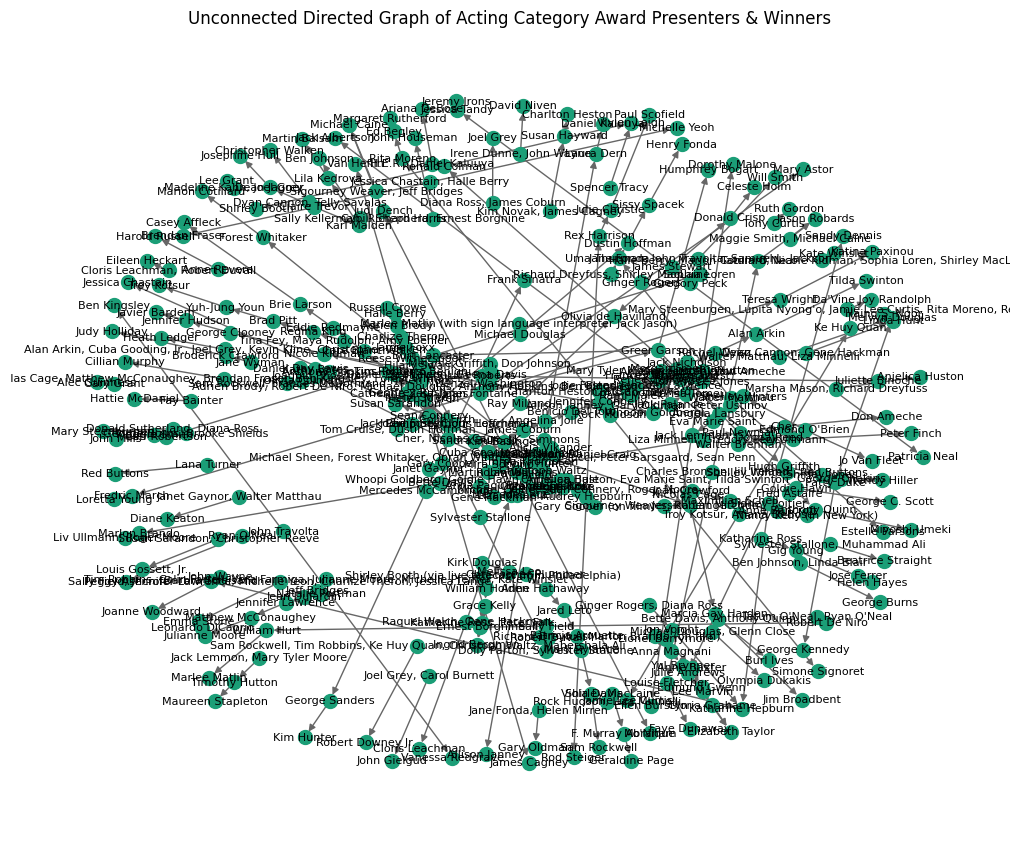

In [ ]:
D = nx.from_pandas_edgelist(oscars_df, source = "presented_by",
                            target = "winner", edge_attr = "year",
                            create_using = nx.DiGraph())
def plot_graph(graph, fig_sz=(10, 8), node_sz=100, font_sz=8,
               edge_col="#666666", node_col="#1B9E77", seedn=1006,
               tit=""): # Function to plot a graph with NetworkX/Matplotlib
    plt.figure(figsize=fig_sz)
    pos = nx.spring_layout(graph, seed=seedn)
    nx.draw(graph, pos, with_labels=True,
            node_size=node_sz, font_size=font_sz,
            edge_color=edge_col, node_color=node_col)
    plt.title(tit)
    plt.show()
plot_graph(D, tit="Unconnected Directed Graph of Acting Category Award Presenters & Winners")

In [ ]:
def summarize_directed_graph(graph):
    D_info = {"nodes": graph.number_of_nodes(),
              "edges": graph.size(),
              "weakly_connected": nx.is_weakly_connected(graph),
              "strongly_connected": nx.is_strongly_connected(graph)}
    D_info.update({"diameter": nx.diameter(graph.to_undirected()) if D_info["weakly_connected"] or D_info["strongly_connected"] else None})
    return D_info
print(summarize_directed_graph(D))

{'nodes': 370, 'edges': 319, 'weakly_connected': False, 'strongly_connected': False, 'diameter': None}


This directed graph has 370 nodes, 319 edges, and is neither weakly nor strongly connected, so it has no diameter. We reduce the graph to its largest weakly connected component.

In [ ]:
largest_weak_cc = max(nx.weakly_connected_components(D), key=len)
W = D.subgraph(largest_weak_cc)
print(summarize_directed_graph(W))

{'nodes': 168, 'edges': 171, 'weakly_connected': True, 'strongly_connected': False, 'diameter': 40}


The largest weakly connected component subgraph has 168 nodes, 171 edges, and a diameter of 40. We visualize this subgraph below.

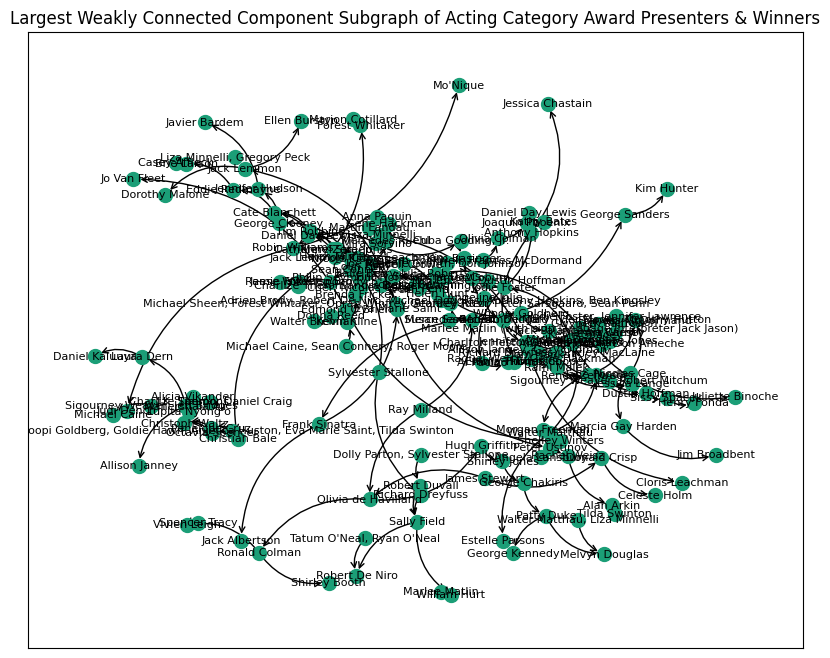

In [ ]:
def plot_graph2(graph, fig_sz=(10, 8), node_sz=100, font_sz=8, font_col = "black",
                edge_col="#666666", edge_w=1, node_col="#1B9E77", seedn=1006,
                arrow_st="->", arrow_sz=10, arrow=True, cs="arc3,rad=0.3",
                tit=""): # Function to plot a graph with NetworkX/Matplotlib
    plt.figure(figsize=fig_sz)
    pos = nx.spring_layout(graph, seed=seedn)
    nodes = nx.draw_networkx_nodes(graph, pos,
                                   node_size=node_sz,
                                   node_color=node_col)
    edges = nx.draw_networkx_edges(graph, pos, node_size=node_sz, arrows=arrow,
                                   arrowstyle=arrow_st, arrowsize=arrow_sz,
                                   width=edge_w, connectionstyle=cs)
    labs = {}
    for n in graph.nodes():
        labs[n] = n
    labels = nx.draw_networkx_labels(graph, pos, labs, font_size=font_sz,
                                     font_color=font_col)
    plt.title(tit)
    plt.show()
plot_graph2(W, tit="Largest Weakly Connected Component Subgraph of Acting Category Award Presenters & Winners")

We reduce the graph to its largest strongly connected component.

In [ ]:
largest_strong_cc = max(nx.strongly_connected_components(D), key=len)
S = D.subgraph(largest_strong_cc)
print(summarize_directed_graph(S))

{'nodes': 8, 'edges': 8, 'weakly_connected': True, 'strongly_connected': True, 'diameter': 4}


The largest strongly connected component subgraph has 8 nodes, 8 edges, and a diameter of 4. We visualize this subgraph below.

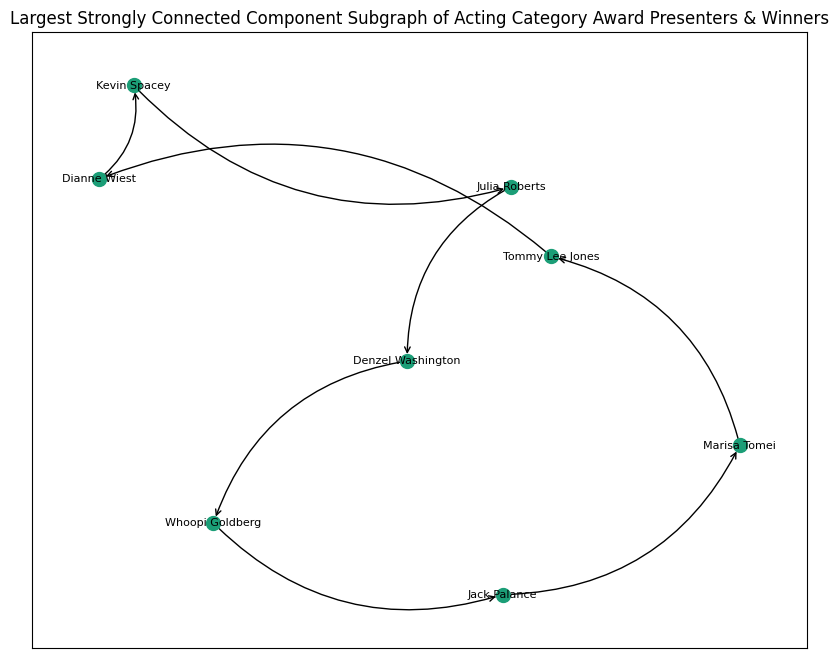

In [ ]:
plot_graph2(S, tit="Largest Strongly Connected Component Subgraph of Acting Category Award Presenters & Winners")

This is an interesting closed loop of presenters and winners, meaning everyone in this group has both received an award from someone in the group and presented an award to someone else in the group. It doesn't loop back in on itself at any point, as no one here has received an award from the same person they presented an award to.

We return our focus to the largest weakly connected component subgraph since there's not much more we can glean from the largest strongly connected component subgraph, as it's pretty small (despite still being remarkable). We calculate in-degree, out-degree, and betweenness centrality measures for the largest weakly connected component subgraph.

In [ ]:
def calc_node_cent_meas(graph, sort=["In-Degree Centrality", "Index"]):
    in_degree_centrality = round(pd.Series(nx.in_degree_centrality(graph)).to_frame("In-Degree Centrality"), 3)
    out_degree_centrality = round(pd.Series(nx.out_degree_centrality(graph)).to_frame("Out-Degree Centrality"), 3)
    betweenness_centrality = round(pd.Series(nx.betweenness_centrality(graph)).to_frame("Betweenness Centrality"), 3)
    centrality_df = in_degree_centrality.merge(out_degree_centrality, how="left", left_index=True, right_index=True)
    centrality_df = centrality_df.merge(betweenness_centrality, how="left", left_index=True, right_index=True)
    centrality_df.index.name = "Index"
    centrality_df.sort_values(by=sort, ascending=[False, True], inplace=True)
    centrality_df.index.name = None
    return centrality_df

In-Degree Centrality allows us to see the actors/actresses who have won the most awards in this group. Below are the top five winners according to this measure.

In [ ]:
print("\nTop 5 Winners by In-Degree Centrality: \n")
calc_node_cent_meas(W).head(5)


Top 5 Winners by In-Degree Centrality: 



,In-Degree Centrality,Out-Degree Centrality,Betweenness Centrality
Frances McDormand,0.018,0.006,0.046
Jack Nicholson,0.018,0.006,0.068
Meryl Streep,0.018,0.006,0.001
Anthony Hopkins,0.012,0.012,0.010
Cate Blanchett,0.012,0.006,0.010


We can see that Frances McDormand, Jack Nicholson, and Meryl Streep share the highest In-Degree Centrality values, so they have won the most awards in this group.

In contrast to In-Degree Centrality, Out-Degree Centrality allows us to see the people who have presented the most awards in this group. Below are the top five presenters according to this centrality measure.

In [ ]:
calc_node_cent_meas(W, sort=["Out-Degree Centrality", "Index"]).head(5)

,In-Degree Centrality,Out-Degree Centrality,Betweenness Centrality
Walter Matthau,0.006,0.018,0.018
Anthony Hopkins,0.012,0.012,0.010
Denzel Washington,0.012,0.012,0.074
Edmond O'Brien,0.006,0.012,0.004
Eva Marie Saint,0.006,0.012,0.006


Walter Matthau has the highest Out-Degree Centrality value, so he has presented the most awards in this group.

Lastly, Betweenness Centrality allows us to see the connective tissue in this group, i.e. the people who most frequently lie along the shortest paths between others. The top five presenters/winners according to this centrality measure are below.

In [ ]:
calc_node_cent_meas(W, sort=["Betweenness Centrality", "Index"]).head(5)

,In-Degree Centrality,Out-Degree Centrality,Betweenness Centrality
Kevin Spacey,0.012,0.012,0.075
Denzel Washington,0.012,0.012,0.074
Julia Roberts,0.006,0.006,0.072
Gwyneth Paltrow,0.006,0.006,0.068
Hilary Swank,0.012,0.012,0.068


Kevin Spacey has the highest Betweenness Centrality value, but Denzel Washington is a close second, and Julia Roberts is a close third. They represent frequent bridges between other presenters/winners. Note that all three of them were featured in the largest strongly connected component subgraph we looked at earlier.

## Text Analysis

Our text analysis will focus on the speeches of the winners of these awards, including the people who have accepted them on the winners' behalfs. Most actors/actresses tend to be available to accept their own awards in recent years, but it was more common in the past for people to be unable to attend, usually due to acting projects they were undertaking in other countries. Occasionally, the winner has not been in attendance, and no one has accepted the award on their behalf either, so there was no speech given or recorded.

Due to the nature of the event, the fact that each speaker is receiving an award, and our general knowledge of most award acceptance speeches, the sentiment of these speeches was presumed to be positive, and the general topic was presumed to be gratitude. We want to identify the subjects of these speakers' gratitude, i.e. who they are thanking for their success, so we export the speeches for manual labeling.

The labels we applied were five binary indicator variables (with values of 1 indicating "Yes" and values of 0 indicating "No"). Below is the list of these variables and their descriptions:

In [ ]:
my_url2 = "https://raw.githubusercontent.com/geedoubledee/data620_finalproject/main/label_descriptions.csv"
label_descriptions = pd.read_csv(my_url2)
label_descriptions.head()

,Variable,Description
0,GOD,Did the recipient thank a deity?
1,COLLEAGUE,Did the recipient thank other people in showbu...
2,FAMILY,Did the recipient thank members of their family?
3,FRIEND,Did the recipient thank their friends?
4,TEACHER,"Did the recipient thank someone who taught, tr..."


Note that we ignored whether speeches thanked the Academy because we considered it perfunctory. We load the newly labeled data, and we display the first five observations in the labeled dataset here.

In [ ]:
oscars_df.to_csv("oscars_acc_spe_act_cats_only_for_labs.csv", encoding = "utf-8", index = False)
my_url3 = "https://raw.githubusercontent.com/geedoubledee/data620_finalproject/main/oscars_acc_spe_act_cats_only_labeled.csv"
oscars_df_labeled = pd.read_csv(my_url3)
oscars_df_labeled.head()

,year,award_no,presented_by,category,film,winner,speech,GOD,COLLEAGUE,FAMILY,FRIEND,TEACHER
0,1939,12,Spencer Tracy,Actress,Gone with the Wind,Vivien Leigh,"VIVIEN LEIGH:\n\r Ladies and gentlemen, please...",0,1,0,0,0
1,1939,12,Fay Bainter,Actress in a Supporting Role,Gone with the Wind,Hattie McDaniel,HATTIE McDANIEL:\n\r Academy of Motion Picture...,0,0,0,0,0
2,1941,14,James Stewart,Actor in a Supporting Role,How Green Was My Valley,Donald Crisp,"DONALD CRISP:\n\r Ladies and gentlemen, it's a...",0,1,0,1,0
3,1941,14,Ginger Rogers,Actress,Suspicion,Joan Fontaine,JOAN FONTAINE:\n\r I want to thank the ladies ...,0,1,0,0,0
4,1941,14,Ginger Rogers,Actress in a Supporting Role,The Great Lie,Mary Astor,"MARY ASTOR:\n\r Ladies and gentlemen, twenty-t...",0,0,0,0,0


To prepare the labeled data for further analysis, we start by removing any observations where no speech was given or recorded.

In [ ]:
oscars_df_labeled.dropna(axis = 0, inplace = True)
oscars_df_labeled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 312 entries, 0 to 318
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   year          312 non-null    int64 
 1   award_no      312 non-null    int64 
 2   presented_by  312 non-null    object
 3   category      312 non-null    object
 4   film          312 non-null    object
 5   winner        312 non-null    object
 6   speech        312 non-null    object
 7   GOD           312 non-null    int64 
 8   COLLEAGUE     312 non-null    int64 
 9   FAMILY        312 non-null    int64 
 10  FRIEND        312 non-null    int64 
 11  TEACHER       312 non-null    int64 
dtypes: int64(7), object(5)
memory usage: 31.7+ KB


That leaves us with 312 observations. We now visualize the distributions of the labels we applied.

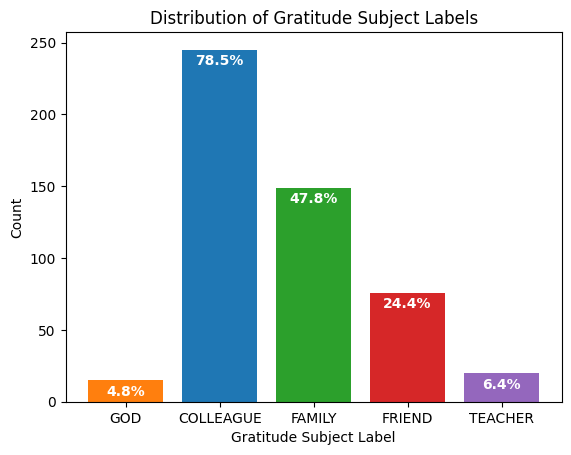

In [ ]:
x = ["GOD", "COLLEAGUE", "FAMILY", "FRIEND", "TEACHER"]
y = [oscars_df_labeled[oscars_df_labeled.GOD == 1].shape[0],
     oscars_df_labeled[oscars_df_labeled.COLLEAGUE == 1].shape[0],
     oscars_df_labeled[oscars_df_labeled.FAMILY == 1].shape[0],
     oscars_df_labeled[oscars_df_labeled.FRIEND == 1].shape[0],
     oscars_df_labeled[oscars_df_labeled.TEACHER == 1].shape[0]]
fig, ax = plt.subplots()
bars = ax.bar(x, y, color = ["tab:orange", "tab:blue", "tab:green", "tab:red",
                             "tab:purple"])
ax.set_xlabel("Gratitude Subject Label")
ax.set_ylabel("Count")
ax.set_title("Distribution of Gratitude Subject Labels")
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        perc_str = str(round(100 * height / len(oscars_df_labeled), 1)) + "%"
        ax.text(bar.get_x() + bar.get_width()/2., height - 3,
                '%s' % perc_str, ha = "center", va = "top",
                color = "white", weight = "bold", size = 10)
autolabel(bars)
plt.show()

Very few of the speeches we labeled expressed gratitude toward a deity or teacher. It was most common for speeches to express gratitude toward colleagues, with around three quarters of speeches doing so. Only around half of speeches thanked family members, and only around a quarter of speeches thanked friends.

We visualize how the frequency of gratitude subjects has changed over time using a 10-year moving average.

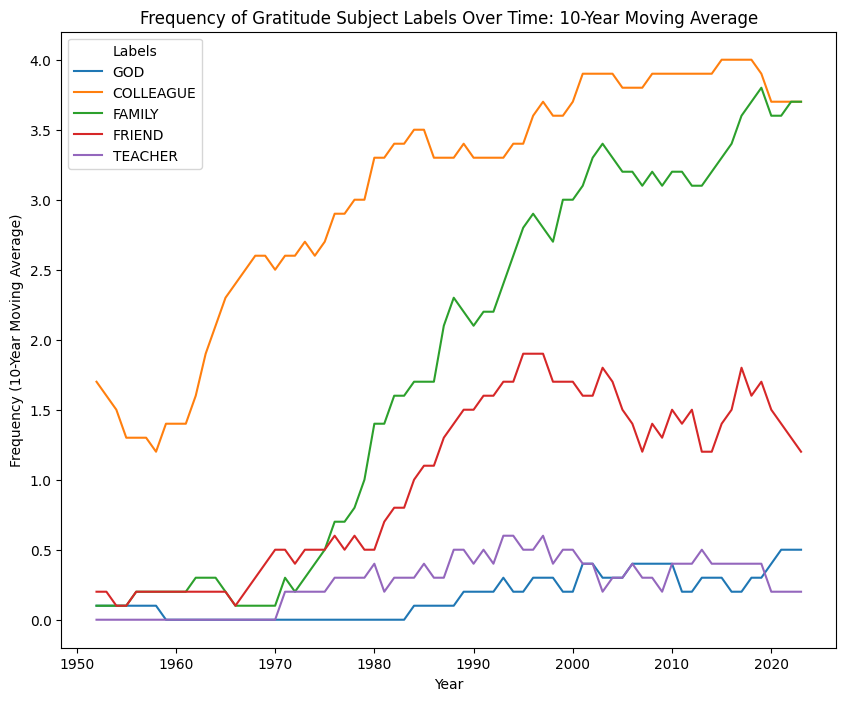

In [ ]:
oscars_df_labeled["year"] = oscars_df_labeled["year"].astype(int)
# Initialize a dictionary to store counts for each label per year
label_counts = {label: [] for label in ["GOD", "COLLEAGUE", "FAMILY", "FRIEND", "TEACHER"]}
label_counts
years = sorted(oscars_df_labeled["year"].unique())
# Count occurrences
for year in years:
    year_data = oscars_df_labeled[oscars_df_labeled["year"] == year]
    for k in label_counts.keys():
        label_counts[k].append(year_data[k].sum())
# Convert to a DataFrame for easier plotting
label_counts_df = pd.DataFrame(label_counts, index=years)
# Calc 10-yr Simple Moving Avg
label_mavg_df = label_counts_df.rolling(10).mean()
label_mavg_df.dropna(inplace = True)
# Plot the label trends over time
plt.figure(figsize=(10, 8))
for col in label_mavg_df.columns:
    plt.plot(label_mavg_df.index, label_mavg_df[col], label=col)
plt.xlabel('Year')
plt.ylabel('Frequency (10-Year Moving Average)')
plt.title('Frequency of Gratitude Subject Labels Over Time: 10-Year Moving Average')
plt.legend(title='Labels')
plt.show()

We can see that thanking family members has become much more common over time, even reaching the same 10-year moving average frequency as thanking colleagues in recent years. We also see that thanking friends was becoming more common for a while, then pretty much plateaued. Thanking deities or teachers has never been very common.

Now we begin preparing the text data for tokenization. First, we address some elements from the speech field that do not represent spoken words:

1.   Some speeches include words between brackets to identify the actions of the speaker, someone nearby, or the audience. (Speech transcribers usually only included short bracketed action sections in order to provide enough detail for readers to understand the speech better in the context of what has happening on stage. So most speeches don't include any bracketed action sections at all.) We replace these with empty strings.
2.   All speeches include names in uppercase preceding a colon to identify the speakers, and some of those identifications include parentheticals to clarify who the speaker was (in the event the person speaking was neither the presenter nor the recipient, e.g. they were the host) or where they were speaking from (in the event the person speaking was accepting the award remotely). We replace parentheticals with empty strings, and we extract all speaker names so that we have sets of all speakers for each speech and we can later remove these speaker identifications from the speech text. For the sake of consistency, we have replaced instances of ", JR." in speaker names with " JR." Some names may also be spelled incorrectly, as we had to eliminate non-ascii characters from the speech text in order to enable consistent speaker name extraction.

In [ ]:
oscars_df_labeled["speech"] = oscars_df_labeled["speech"].str.encode('ascii', 'ignore').str.decode('ascii')
oscars_df_labeled["speech"] = oscars_df_labeled["speech"].str.replace("\[.*\]", "", regex = True)
oscars_df_labeled["speech"] = oscars_df_labeled["speech"].str.replace("\s\(.*\):", ":", regex = True)
oscars_df_labeled["speech"] = oscars_df_labeled["speech"].str.replace("\s+:", ":", regex = True)
oscars_df_labeled["speech"] = oscars_df_labeled["speech"].str.replace(",\sJR.", " JR.", regex = True)
speakers = oscars_df_labeled["speech"].str.extractall("(?P<speaker>[A-Z]+[\.\s]?[A-Z]?\.?[A-Za-z\s\-']+[A-Z\.]):")
speakers.reset_index(level = [0, 1], inplace = True)
ren = {"level_0": "speech_num"}
speakers.rename(ren, axis = 1, inplace = True)
speakers["speakers"] = speakers.groupby("speech_num").speaker.agg(set).reindex(speakers.speech_num).values
speakers.drop_duplicates(subset = ["speech_num"], inplace = True)
rem = ["match", "speaker"]
speakers.drop(rem, axis = 1, inplace = True)

We correct a couple of errors that occurred during speaker name extraction that we couldn't figure out how to prevent.

In [ ]:
speakers.at[48, "speakers"] = {'JERRY LEWIS', 'MARISA PAVAN'}
speakers.at[316, "speakers"] = {'RENE ZELLWEGER'}

We remove the extracted speaker names from the speech text.

In [ ]:
speakers["speakers"] = speakers["speakers"].apply(list)
unique_speakers = sorted(set(speakers["speakers"].sum()))
patt = re.compile('|'.join(map(re.escape, unique_speakers)))
oscars_df_labeled["speech"] = [patt.sub("", text) for text in oscars_df_labeled["speech"]]

We perform sentiment analysis of the speeches over time using the Textblob library.

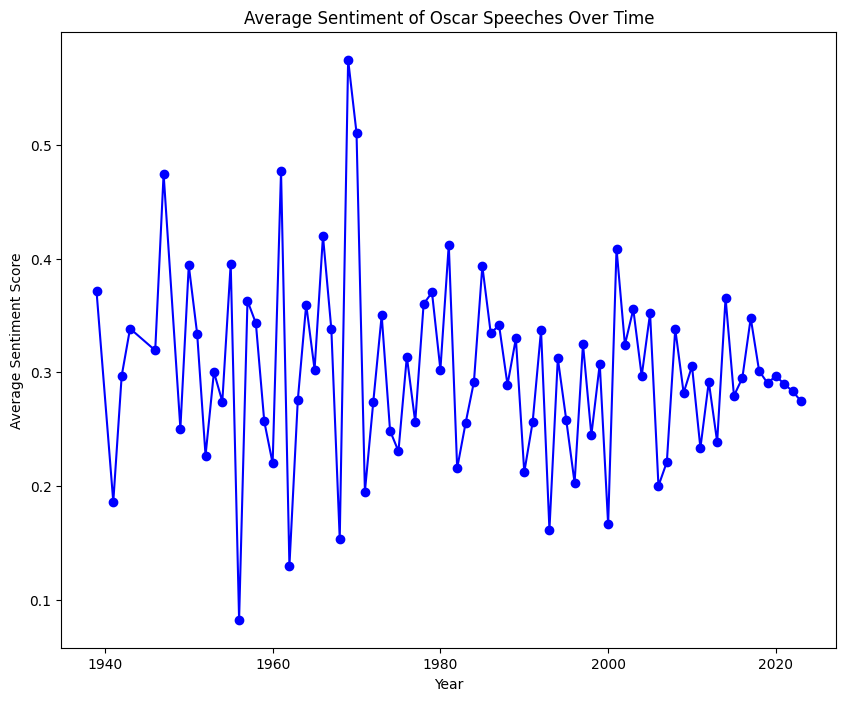

In [ ]:
# Compute sentiment scores
oscars_df_labeled['sentiment'] = oscars_df_labeled['speech'].apply(lambda x: TextBlob(x).sentiment.polarity)
# Group by year and calculate mean sentiment
sentiment_by_year = oscars_df_labeled.groupby('year')['sentiment'].mean()
# Plot sentiment over time
plt.figure(figsize=(10, 8))
plt.plot(sentiment_by_year.index, sentiment_by_year.values, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment of Oscar Speeches Over Time')
plt.show()

We can see that the average sentiment scores tend to fluctuate, with some years averaging closer to zero (meaning the acceptance speeches were more neutral overall) and other years averaging higher (meaning the acceptance speeches were more positive overall). This variability in the general emotional tone of the speeches is interesting since they tended to sound very similar when reading them. In recent years, the fluctuation in the tone of the speeches has leveled off a bit though.

We train logistic regression and random forest models to predict each of the gratitude subject labels. Since there are so few observations for the GOD and TEACHER labels, we don't actually expect any models to perform well when predicting either of them. In our previous experience with such underrepresented classes, many models have tended to predict 0 positive cases, achieving high accuracy because most instances are in fact negative. In achieving such high accuracy, however, the false negative rate for those models becomes 100%. With more time to label data, we could have expanded our analysis to more award categories and could probably have found more observations thanking deities or teachers. But we proceed with the analysis using the data we have and understanding these limitations.

In [ ]:
# Labels to be used as response variables
labels = ["GOD", "COLLEAGUE", "FAMILY", "FRIEND", "TEACHER"]
# Preprocess the speech text
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(oscars_df_labeled['speech'])
# Initialize a dictionary to store results
results = {label: {} for label in labels}
# Split data and train models for each label
for label in labels:
    y = oscars_df_labeled[label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Train a logistic regression model
    model = LogisticRegression()
    model.fit(X_train, y_train)
    # Predict and evaluate using acc, prec, rec, & F1 score
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    # Store the results
    results[label]['model'] = model
    results[label]['model_type'] = "Logistic Regression"
    results[label]['accuracy'] = round(accuracy, 2)
    results[label]['precision'] = round(precision, 2)
    results[label]['recall'] = round(recall, 2)
    results[label]['f1_score'] = round(f1, 2)
# Initialize a dictionary to store results for RandomForest
rf_results = {label: {} for label in labels}
# Split data and train models for each label
for label in labels:
    y = oscars_df_labeled[label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Train a RandomForest classifier
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train, y_train)
    # Predict and evaluate using acc, prec, rec, & F1 score
    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    # Store the results
    rf_results[label]['model'] = rf_model
    rf_results[label]['model_type'] = "Random Forest"
    rf_results[label]['accuracy'] = round(accuracy, 2)
    rf_results[label]['precision'] = round(precision, 2)
    rf_results[label]['recall'] = round(recall, 2)
    rf_results[label]['f1_score'] = round(f1, 2)

The performance metrics for both types of models on all gratitude subject labels are below.

In [ ]:
lr_results_df = pd.DataFrame(results).transpose().reset_index(names="label")
rem = ["model"]
lr_results_df.drop(rem, axis=1, inplace = True)
rf_results_df = pd.DataFrame(rf_results).transpose().reset_index(names="label")
rf_results_df.drop(rem, axis=1, inplace = True)
results_df = pd.concat([lr_results_df, rf_results_df])
results_df.sort_values(by =["label", "model_type"], ascending=[True, True], inplace=True)
results_df

,label,model_type,accuracy,precision,recall,f1_score
1,COLLEAGUE,Logistic Regression,0.78,0.78,1.0,0.88
1,COLLEAGUE,Random Forest,0.84,0.83,1.0,0.91
2,FAMILY,Logistic Regression,0.92,0.93,0.9,0.92
2,FAMILY,Random Forest,0.94,0.96,0.9,0.93
3,FRIEND,Logistic Regression,0.78,0.0,0.0,0.0
3,FRIEND,Random Forest,0.83,1.0,0.21,0.35
0,GOD,Logistic Regression,0.98,0.0,0.0,0.0
0,GOD,Random Forest,0.98,0.0,0.0,0.0
4,TEACHER,Logistic Regression,0.92,0.0,0.0,0.0
4,TEACHER,Random Forest,0.92,0.0,0.0,0.0


As expected, neither type of model was useful for predicting the GOD or TEACHER labels. Performance on the FRIEND label was also low. However, logistic regression and random forest models were both able to perform pretty well on the labels we had the most data for: COLLEAGUE and FAMILY.

The random forest model has the highest accuracy and F1 Score for both labels, so it is the best performer, balancing both precision and recall. The 10 most important features for the random forest model on the COLLEAGUE label were:

In [ ]:
# Extract feature importance estimates from the RF model for COLLEAGUE
feature_imp = rf_results["COLLEAGUE"]["model"].feature_importances_
# Get feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()
# Combine names and importances
feature_imp = zip(feature_names, feature_imp)
feature_imp = sorted(feature_imp, key=lambda x: x[1], reverse=True)
# Print top N most important features
for feature, importance in feature_imp[:10]:
    print(f"{feature}: {importance}")

thank: 0.03505705852420967
say: 0.016814016917119555
academy: 0.01576557045700178
award: 0.011328178449676554
like: 0.010941005020038641
think: 0.01078642234245632
great: 0.010587494582946378
accept: 0.01016001543883343
going: 0.009952630750621411
miss: 0.009481732822118378


And the 10 most important features for the random forest model on the FAMILY label were:

In [ ]:
# Extract feature importance estimates from the RF model for FAMILY
feature_imp = rf_results["FAMILY"]["model"].feature_importances_
# Get feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()
# Combine names and importances
feature_imp = zip(feature_names, feature_imp)
feature_imp = sorted(feature_imp, key=lambda x: x[1], reverse=True)
# Print top N most important features
for feature, importance in feature_imp[:10]:
    print(f"{feature}: {importance}")

cast: 0.02458664621093761
family: 0.02082578405976236
wife: 0.017409858839972578
love: 0.016669672357316933
work: 0.013043570170774416
mother: 0.011154325236596286
world: 0.009896516123972687
support: 0.00945373729004002
like: 0.008866131001159518
movie: 0.00864708450502254


## Conclusion

The features the random forest model used most in predicting the COLLEAGUE label are a little generic, whereas the features it used in predicting the FAMILY label are more specific. We see identifiers like family, wife, and mother. We could probably improve the models for these labels by refining the stopwords we used to be more specific to award acceptance speeches, and like we mentioned earlier, we would probably need to label more data to improve the models for the other labels.

One way in which we could take this analysis further in the future is by customizing named entity recognition to not just identify named entities in the speeches as people, but by their relationships to the speaker. We think it would be particularly fruitful for familial relations. We would probably be able to construct some incomplete, but interesting family trees without resorting to outside data sources.

## Video Presentation

You can [view the video presentation here](https://www.loom.com/share/37b8ce982b144edfad63b8f8cbc8f6a6?sid=7a2fc22f-6383-4c37-80f1-f62059713d83).